Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
Bio = pd.read_csv("Bioefficiency.csv")

In [3]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 0.107
tauc = 20
coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [4]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 26, 46)

In [5]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

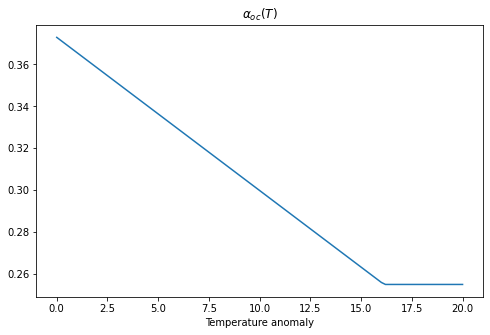

(0.255, 0.372950625)

In [6]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

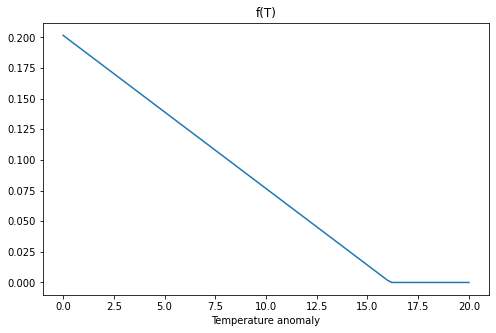

(0.0, 0.20162499999999994)

In [7]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

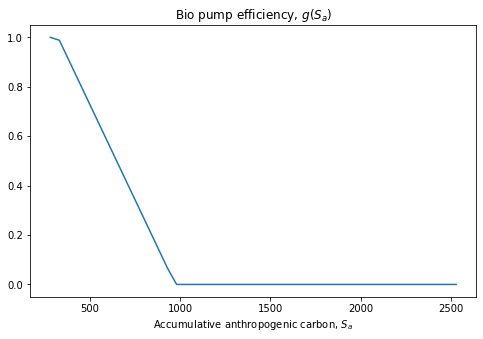

In [8]:
Fo = 272.3
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

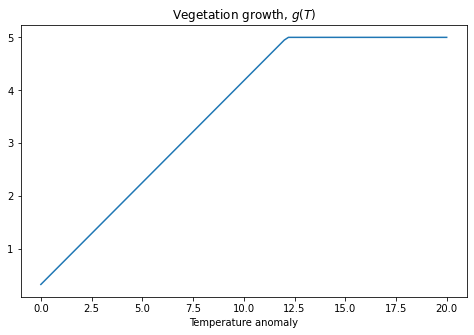

(0.33461538461538637, 5.0)

In [9]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

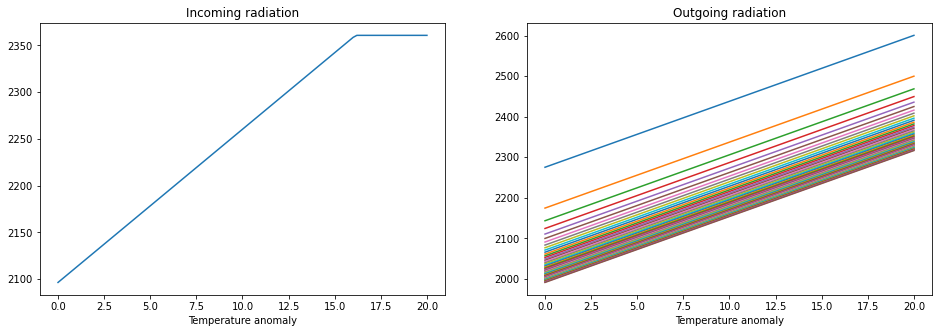

In [10]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

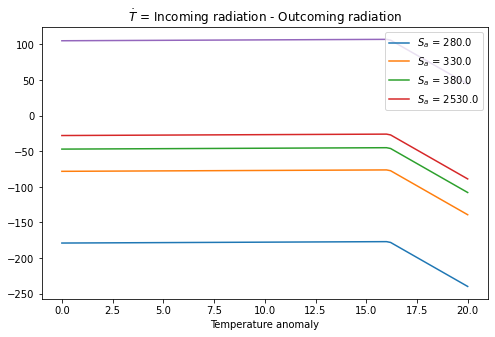

In [11]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [12]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 1130.0, 260)

In [13]:
(ri - ro)[6, 17]

56.88065892593568

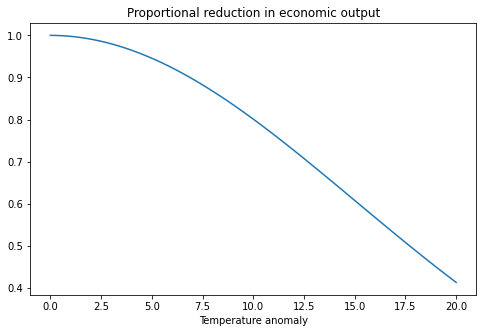

In [14]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [15]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 5. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 350.
hC     = 5.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 400. # 10. avaoid 
F_max = 500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 5.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(26, 21, 21)

In [ ]:
# v0 =  - eta * T_mat - eta * F_mat
v0 =  eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1)  / delta * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

gamma_3 = 0.
dG  = gamma_1 + gamma_2 * T_mat + gamma_3 * (T_mat - 2) * (T_mat > 2)

epsilon  = 10.
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 3000
fraction = 1.


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To) * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat - Fo, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 1e-4 * np.ones(T_mat.shape)
    C2 = 1e-4 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * np.log(Ca) + (eta - 1) /delta * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 440.5310704881359;	 PDE Error: 12071.496900167735	
Iteration: 2;	 False Transient Error: 332.1527708169488;	 PDE Error: 221584.1919220698	
Iteration: 3;	 False Transient Error: 148.49784727596827;	 PDE Error: 1629.6898998711022	
Iteration: 4;	 False Transient Error: 45.882515555941794;	 PDE Error: 101.39415023197502	
Iteration: 5;	 False Transient Error: 30.24729642300298;	 PDE Error: 54.32133227389096	
Iteration: 6;	 False Transient Error: 23.11813519606335;	 PDE Error: 42.69153423898164	
Iteration: 7;	 False Transient Error: 16.331583578612232;	 PDE Error: 333.5085207639088	
Iteration: 8;	 False Transient Error: 14.21859555551573;	 PDE Error: 103.70967362391065	
Iteration: 9;	 False Transient Error: 13.44796013532969;	 PDE Error: 41.02851336319276	
Iteration: 10;	 False Transient Error: 14.262727430125597;	 PDE Error: 84.61888422954604	
Iteration: 11;	 False Transient Error: 7.159656686039415;	 PDE Error: 18.668305920921327	
Iteration: 12;	 False

Iteration: 93;	 False Transient Error: 0.716594484456229;	 PDE Error: 4.790781175164819	
Iteration: 94;	 False Transient Error: 0.5950825548925195;	 PDE Error: 46.25281337538014	
Iteration: 95;	 False Transient Error: 0.5027956412210983;	 PDE Error: 5.636556159008068	
Iteration: 96;	 False Transient Error: 0.6142702943625181;	 PDE Error: 4.705453321886994	
Iteration: 97;	 False Transient Error: 0.6486755786931099;	 PDE Error: 18.001259800973237	
Iteration: 98;	 False Transient Error: 0.5798524700142877;	 PDE Error: 9.021220212246162	
Iteration: 99;	 False Transient Error: 0.5990485506260939;	 PDE Error: 4.570455346383524	
Iteration: 100;	 False Transient Error: 0.788182779166766;	 PDE Error: 15.735613840445607	
Iteration: 101;	 False Transient Error: 6.0621454411117215;	 PDE Error: 6.554085929762035	
Iteration: 102;	 False Transient Error: 4.978899043842858;	 PDE Error: 30.18868343502683	
Iteration: 103;	 False Transient Error: 2.542347194055799;	 PDE Error: 12.884355706059251	
Iterati

Iteration: 184;	 False Transient Error: 0.9022015590498086;	 PDE Error: 4.935044559161568	
Iteration: 185;	 False Transient Error: 0.871112429781482;	 PDE Error: 7.406624796878	
Iteration: 186;	 False Transient Error: 1.7016151379883895;	 PDE Error: 5.289473970290028	
Iteration: 187;	 False Transient Error: 2.9353242004445264;	 PDE Error: 7.5532099428395	
Iteration: 188;	 False Transient Error: 2.382780182505397;	 PDE Error: 11.068039877568857	
Iteration: 189;	 False Transient Error: 2.112952377681805;	 PDE Error: 5.942232995375091	
Iteration: 190;	 False Transient Error: 5.117218479352391;	 PDE Error: 6.482534594465093	
Iteration: 191;	 False Transient Error: 2.1527488567516997;	 PDE Error: 11.076396865837172	
Iteration: 192;	 False Transient Error: 1.0637410540654144;	 PDE Error: 6.175489719075963	
Iteration: 193;	 False Transient Error: 1.001291842780023;	 PDE Error: 5.361576260558962	
Iteration: 194;	 False Transient Error: 0.8958490766959357;	 PDE Error: 10.493951847549411	
Iterat

Iteration: 275;	 False Transient Error: 15.90456125302082;	 PDE Error: 24.76238768096031	
Iteration: 276;	 False Transient Error: 7.20313011582387;	 PDE Error: 12.681490306925747	
Iteration: 277;	 False Transient Error: 2.9443973746905217;	 PDE Error: 4.976039276999871	
Iteration: 278;	 False Transient Error: 1.822715458844948;	 PDE Error: 5.158493781539416	
Iteration: 279;	 False Transient Error: 1.6456162663536333;	 PDE Error: 21.016380351309607	
Iteration: 280;	 False Transient Error: 0.9674554339963549;	 PDE Error: 7.301243451793287	
Iteration: 281;	 False Transient Error: 0.9739651302295954;	 PDE Error: 9.35026091099599	
Iteration: 282;	 False Transient Error: 0.46419618595136286;	 PDE Error: 5.281068870105811	
Iteration: 283;	 False Transient Error: 0.7529096962847547;	 PDE Error: 10.322010599177759	
Iteration: 284;	 False Transient Error: 0.470260549961074;	 PDE Error: 6.867257537849804	
Iteration: 285;	 False Transient Error: 0.6055007912756196;	 PDE Error: 13.38609885481494	
I

Iteration: 365;	 False Transient Error: 1.451749931946003;	 PDE Error: 19.26120888729777	
Iteration: 366;	 False Transient Error: 1.9412336354094832;	 PDE Error: 15.35807511182142	
Iteration: 367;	 False Transient Error: 1.5975122814643385;	 PDE Error: 19.235497217715732	
Iteration: 368;	 False Transient Error: 1.60025117980463;	 PDE Error: 18.22600921591977	
Iteration: 369;	 False Transient Error: 1.3501792993306168;	 PDE Error: 8.697775505162642	
Iteration: 370;	 False Transient Error: 1.154659768244997;	 PDE Error: 27.80904042781843	
Iteration: 371;	 False Transient Error: 1.1212803755346386;	 PDE Error: 10.69430516803246	
Iteration: 372;	 False Transient Error: 1.1208729462459162;	 PDE Error: 5.4352393256336615	
Iteration: 373;	 False Transient Error: 0.9692168104147584;	 PDE Error: 8.530827349325305	
Iteration: 374;	 False Transient Error: 0.5324151447528976;	 PDE Error: 35.661052831988364	
Iteration: 375;	 False Transient Error: 0.8496694583226627;	 PDE Error: 12.795995643834726	

Iteration: 456;	 False Transient Error: 1.9892549145728367;	 PDE Error: 8.616023472719009	
Iteration: 457;	 False Transient Error: 2.053014188623737;	 PDE Error: 4.653542066192684	
Iteration: 458;	 False Transient Error: 1.4866869980979203;	 PDE Error: 6.425868596970318	
Iteration: 459;	 False Transient Error: 0.9320727683805472;	 PDE Error: 3.7163914368552193	
Iteration: 460;	 False Transient Error: 1.2633727688078664;	 PDE Error: 5.001322942288265	
Iteration: 461;	 False Transient Error: 0.8400366907539564;	 PDE Error: 5.3286457794440105	
Iteration: 462;	 False Transient Error: 0.607062823049722;	 PDE Error: 21.46106975791995	
Iteration: 463;	 False Transient Error: 0.37443440663855654;	 PDE Error: 10.012522786799966	
Iteration: 464;	 False Transient Error: 3.669716973649949;	 PDE Error: 7.916728320731954	
Iteration: 465;	 False Transient Error: 3.2880734524505555;	 PDE Error: 18.568042257744807	
Iteration: 466;	 False Transient Error: 0.7706035090615956;	 PDE Error: 5.64552690539829

Iteration: 546;	 False Transient Error: 1.0798720256745127;	 PDE Error: 5.465242518050658	
Iteration: 547;	 False Transient Error: 1.857808414675165;	 PDE Error: 8.029410174551298	
Iteration: 548;	 False Transient Error: 7.358829687061672;	 PDE Error: 8.112625495794955	
Iteration: 549;	 False Transient Error: 15.010470487974297;	 PDE Error: 16.88215361017252	
Iteration: 550;	 False Transient Error: 6.570541782235708;	 PDE Error: 13.20948689340497	
Iteration: 551;	 False Transient Error: 3.421953173268446;	 PDE Error: 16.728080636200445	
Iteration: 552;	 False Transient Error: 1.9688517465351452;	 PDE Error: 6.722131833044733	
Iteration: 553;	 False Transient Error: 1.2619181881196766;	 PDE Error: 4.045706362372747	
Iteration: 554;	 False Transient Error: 0.8902230981924617;	 PDE Error: 13.3989678849537	
Iteration: 555;	 False Transient Error: 0.6657629849483812;	 PDE Error: 8.516869254678753	
Iteration: 556;	 False Transient Error: 0.5204544853237081;	 PDE Error: 8.271542271025778	
Ite

In [69]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(12.532383465243583,
 -4.906736543387979,
 -9766.494602690369,
 -2321.743677401739,
 124.68497349219182,
 1e-32,
 16.65195235315793,
 -2321.743677401739,
 2822.533325931456,
 124.68497349219182,
 -9766.494602690369)

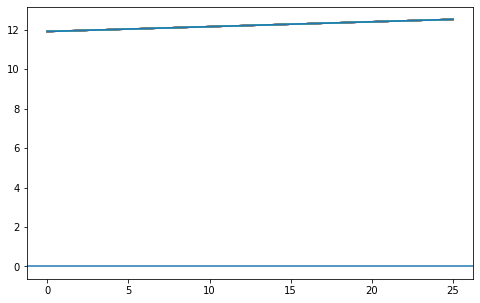

In [70]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

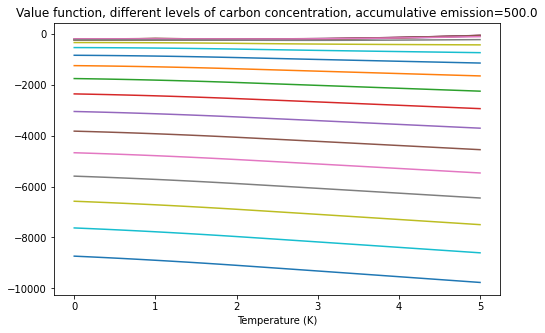

In [71]:
ii = -1
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

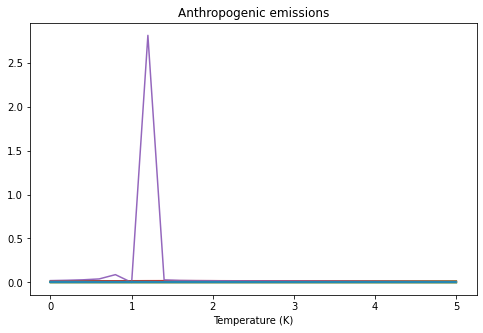

In [72]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

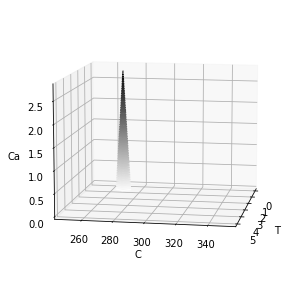

In [73]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [65]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + 1.1
C_0 = 275.5
F_0 = 408.45

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To)
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, '$S_a$')

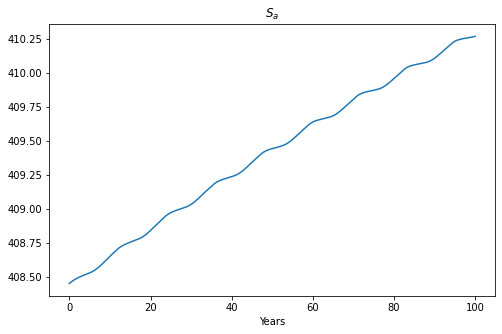

In [66]:
plt.plot(years, hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

Text(0.5, 1.0, 'Emission')

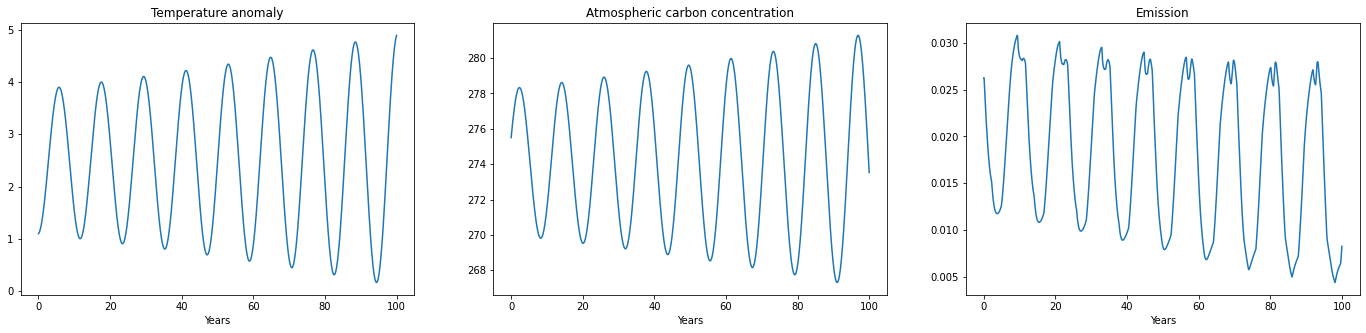

In [67]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")